# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть LSTM на любом другом датасете. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
</ol>

## Будем предсказывать дневные цены закрытия акций Газпрома (тикер 'GAZP' на MOEX) на основе 10-летнего временного ряда##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas_datareader.data import DataReader

from datetime import datetime

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#files.upload()
#!ls

In [3]:
df = pd.read_csv('/content/GAZP_10_yrs.csv', sep= ',', engine='python')
df.tail()

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
2520,20200710,198.25,201.70,197.22,200.94,39028520
2521,20200713,201.60,202.33,195.50,195.70,62999870
2522,20200714,195.09,196.65,192.48,193.60,83060710
2523,20200715,180.60,184.27,179.80,182.26,73463320
2524,20200716,181.20,183.79,181.07,183.76,25395950


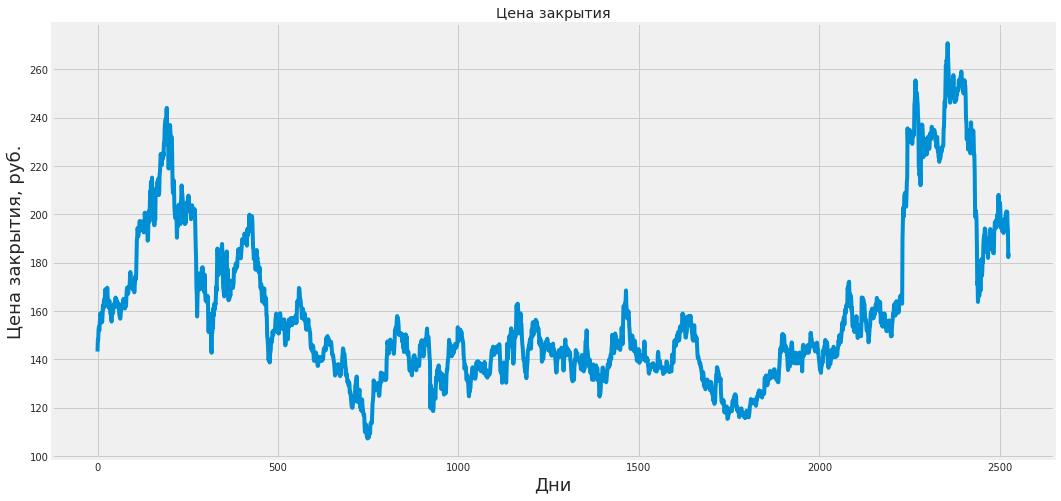

In [4]:
plt.figure(figsize=(16,8))
plt.title('Цена закрытия')
plt.plot(df['CLOSE'])
plt.xlabel('Дни', fontsize=18)
plt.ylabel('Цена закрытия, руб.', fontsize=18)
plt.show()

Посмотрим есть ли Null/Nan значения

In [5]:
df.isna().sum()

DATE     0
OPEN     0
HIGH     0
LOW      0
CLOSE    0
VOL      0
dtype: int64

In [6]:
# Создаем новый df, оставляя только колонку close/закрытие
data = df.filter(['CLOSE'])

# конвертация df в массив numpy
dataset = data.values

# выпиливыем тренировочный датасет
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

2020

In [7]:
# нормализация данных, чтобы градиент не свихнулся по дороге к успеху

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.21998655],
       [0.25087151],
       [0.24964834],
       ...,
       [0.52822457],
       [0.45887102],
       [0.46804477]])

In [8]:
# нормализация тренировочного датасета

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.21998655, 0.25087151, 0.24964834, 0.2761299 , 0.28279616,
       0.27362241, 0.28726072, 0.29906428, 0.3168002 , 0.31123479,
       0.30499664, 0.29331539, 0.30248914, 0.29502783, 0.31202985,
       0.33679897, 0.32823681, 0.33575928, 0.34903064, 0.3336799 ,
       0.35636964, 0.34016268, 0.3777139 , 0.35893829, 0.36578803,
       0.3652376 , 0.36480949, 0.38150572, 0.36266895, 0.33679897,
       0.33759403, 0.33043851, 0.34218091, 0.34841906, 0.33741056,
       0.32334414, 0.31496545, 0.31728946, 0.30193872, 0.29588404,
       0.31478197, 0.31392575, 0.31661672, 0.3175341 , 0.3336799 ,
       0.33985689, 0.34108006, 0.34077426, 0.33215094, 0.34805211,
       0.35655312, 0.34964222, 0.35331172, 0.34108006, 0.34640083,
       0.34211975, 0.33606507, 0.34199743, 0.34193627, 0.32762522])]
[0.3179622041465354]



In [9]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1960, 60, 1)

In [11]:
# строим модель LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='MSE')

In [13]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1960/1960 [==============================] - 70s 36ms/step - loss: 0.0015


In [14]:
# создаем тестовый датасет

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [15]:

x_test = np.array(x_test)

In [16]:

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [17]:

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6.498364578217086

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


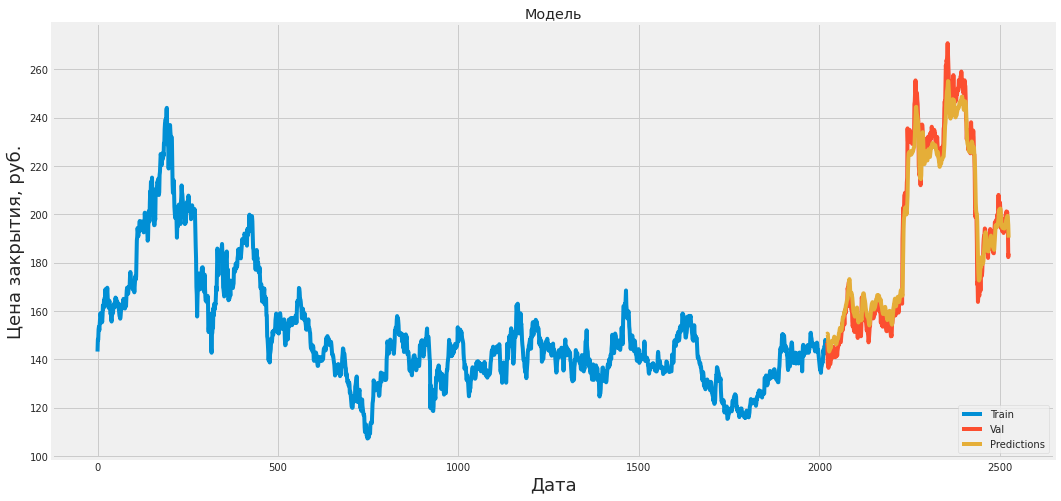

In [20]:

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Модель')
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Цена закрытия, руб.', fontsize=18)
plt.plot(train['CLOSE'])
plt.plot(valid[['CLOSE', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
#Show the valid and predicted prices
valid

,CLOSE,Predictions
2020,146.87,150.208862
2021,147.00,150.297241
2022,145.31,150.652115
2023,138.29,150.506500
2024,137.58,148.169724
...,...,...
2520,200.94,199.029953
2521,195.70,199.324112
2522,193.60,197.791092
2523,182.26,195.576981


Переработал код из методички, максимально упростив. Подбирал параметры с количеством слоев, ядер и batch-size, пока не получил удовлетворительный результат.